### Setup

In [2]:
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
   Installed PlotThemes ─ v3.2.0
  No Changes to `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Project.toml`
    Updating `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Manifest.toml`
  [ccf2f8ad] ↑ PlotThemes v3.1.0 ⇒ v3.2.0
Precompiling project...
  ✓ PlotThemes
  1 dependency successfully precompiled in 6 seconds. 196 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
┌ Info: We haven't cleaned this depot up for a bit, running Pkg.gc()...
└ @ Pkg C:\Users\domin\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Pkg\src\Pkg.jl:789
      Active manifest files: 5 found
      Active artifact files: 138 found
      Active scratchspaces: 3 found
     Deleted 12 package installa

In [5]:
using Dragoon
using Plots
using HDF5
# using Dates

In [50]:
n = 8 # number of discs in the booster

initdist = findpeak1d(18.65e9,n; eps=9.35,tand=3e-5,granularity=100_000,deviation=0.4) # initial disc configuration

freqs = genFreqs(18.65e9,10e6; n=100) # optimize on these frequencies
freqsplot = genFreqs(18.65e9,500e6; n=1000) # plot with these frequencies

booster = AnalyticalBooster(initdist; ndisk=n,ϵ=9.35,tand=3e-5,R=0.1)  # physical properties of the booster

hist = initHist(booster,10000,freqs,ObjAnalytical); # stores measurements

### Optimizer

In [51]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-9,
                    ObjAnalytical,
                    InitSimplexCoord(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e3),
                    traceevery=20,
                    showtrace=true,
                    showevery=1000,
                    unstuckisiter=true);

Iter: 1000, timestamp: 3 minutes, 7 seconds
Iter finished. Objective value: -6484.969

Terminated. Max iterations reached.
Final objective value: -6484.969
Elapsed movement time:  3 minutes, 7 seconds
Summed distance:   0.05
Elapsed computing time: 1 second, 23 milliseconds


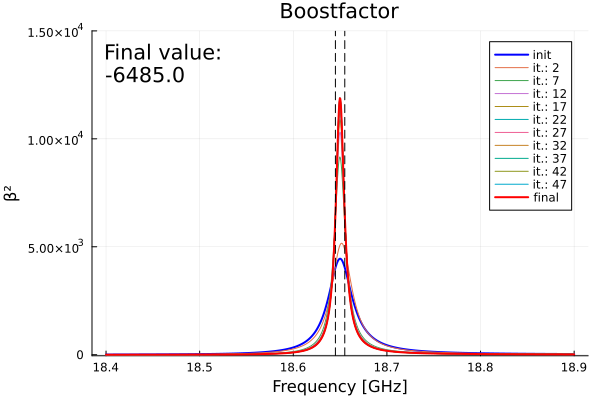

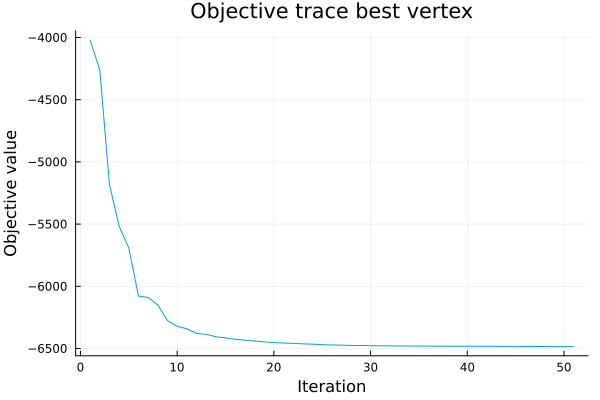

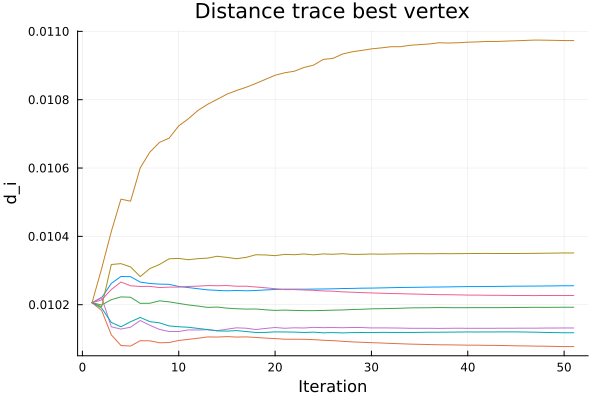

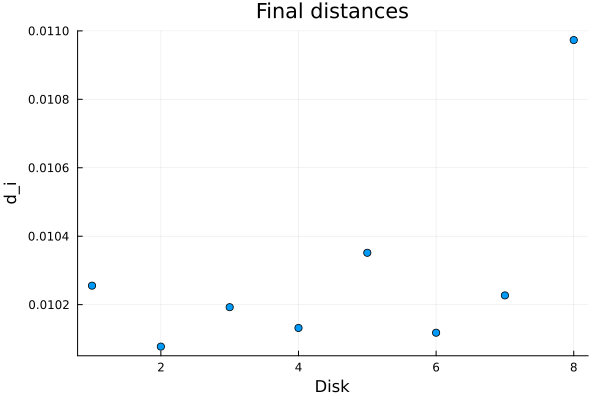

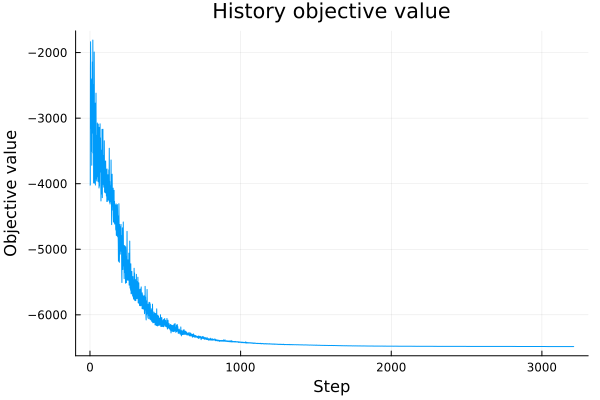

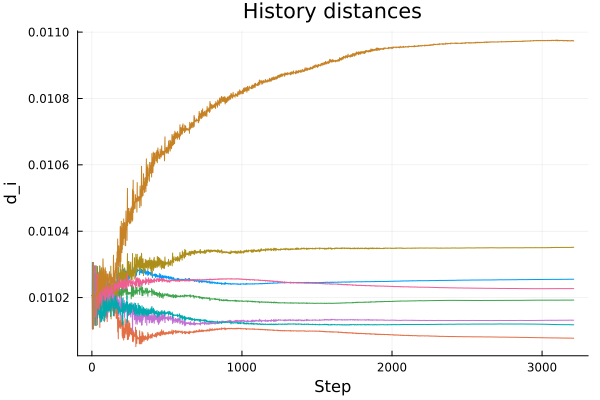

"c:\\Users\\domin\\OneDrive\\Desktop\\Julia Files\\Dragoon.jl\\examples\\final distances.svg"

In [52]:
#get handy output
plt = analyse(booster,hist,trace,freqsplot; freqs=freqs,div=10,ylim=[-50,15000])

savefig(plt[1],"boost process.svg")
savefig(plt[3],"distance process.svg")
savefig(plt[4],"final distances.svg")

In [53]:
obj = zeros(length(trace))
dists = zeros(length(trace),booster.ndisk)
boost = zeros(length(trace),length(freqs))
ref = zeros(ComplexF64,length(trace),length(freqs))

for i in eachindex(trace)
    obj[i] = trace[i].obj[1]
    dists[i,:] = pos2dist(trace[i].x[:,1])
    boost[i,:] = boost1d(dists[i,:],freqs; eps=9.35,tand=3e-5)
    ref[i,:] = ref1d(dists[i,:],freqs; eps=9.35,tand=3e-5)
end

In [54]:
h5write("$(n)discs.h5","data/obj",obj)
h5write("$(n)discs.h5","data/dists",dists)
h5write("$(n)discs.h5","data/boost",boost)
h5write("$(n)discs.h5","data/ref",ref)
h5write("$(n)discs.h5","data/freqs",freqs)

In [22]:
N = collect(4:20)
BW = collect(5:5:100)

OBJ = zeros(Float64,length(N),length(BW))

for (i,n) in enumerate(N)
    println("ndisk: ",n)
    initdist = findpeak1d(18.65e9,n; eps=9.35,tand=3e-5,granularity=100_000,deviation=0.4) # initial disc configuration
    println("initdist: ",initdist)
    for (j,bw) in enumerate(BW)
        println("bandwidth: ",bw," MHz")

        freqs = genFreqs(18.65e9,bw*1e6; n=100) # optimize on these frequencies
        # freqsplot = genFreqs(18.65e9,bw*1e7; n=1000) # plot with these frequencies

        booster = AnalyticalBooster(initdist; ndisk=n,ϵ=9.35,tand=3e-5,R=0.1)  # physical properties of the booster

        hist = initHist(booster,10000,freqs,ObjAnalytical); # stores measurements

        trace, term = nelderMead(booster,hist,freqs,
                    1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-9,
                    ObjAnalytical,
                    InitSimplexCoord(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e3),
                    showtrace=false,
                    showevery=typemax(Int),
                    unstuckisiter=true,
                    returntimes=true);

        OBJ[i,j] = term[1]

        println("objective value: ",term[1])
    end
end

ndisk: 4
initdist: 0.009943323121315396
bandwidth: 5 MHz
objective value: -4899.704863718152
bandwidth: 10 MHz
objective value: -2845.303536908615
bandwidth: 15 MHz
objective value: -1999.7324493724311
bandwidth: 20 MHz
objective value: -1700.7681360365568
bandwidth: 25 MHz
objective value: -1393.1463693010592
bandwidth: 30 MHz
objective value: -1223.9261618926637
bandwidth: 35 MHz
objective value: -1058.094661840561
bandwidth: 40 MHz
objective value: -869.4612063400975
bandwidth: 45 MHz
objective value: -835.4484992589532
bandwidth: 50 MHz
objective value: -721.3785473515895
bandwidth: 55 MHz
objective value: -713.9717909045705
bandwidth: 60 MHz
objective value: -640.4361580513666
bandwidth: 65 MHz
objective value: -600.8605535302673
bandwidth: 70 MHz
objective value: -575.7490877557918
bandwidth: 75 MHz
objective value: -510.02041845694305
bandwidth: 80 MHz
objective value: -508.06865834272367
bandwidth: 85 MHz
objective value: -470.8000807493993
bandwidth: 90 MHz
objective value: -4

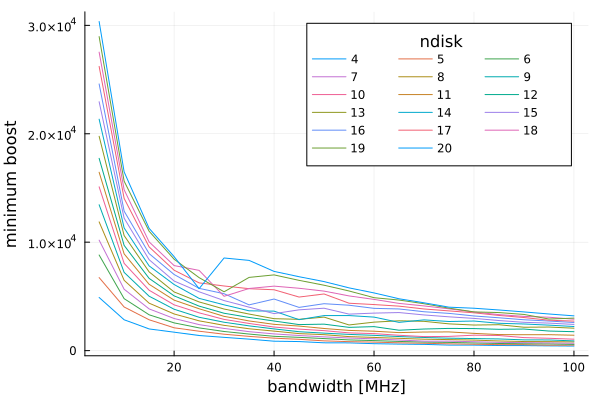

In [23]:
plot(BW,-OBJ'; label=N',legendtitle="ndisk",xlabel="bandwidth [MHz]", ylabel="minimum boost",legendcolumns=3)
# plot!(BW,1.5e4/0.2 ./BW; label="const/BW",c=:red,lw=2)